Loaded 2410 beers
HMM Training Complete!
Initial probabilities: [0.14605809 0.58049793 0.27344398]
Transition matrix shape: (3, 3)
Emission matrix shape: (3, 4)


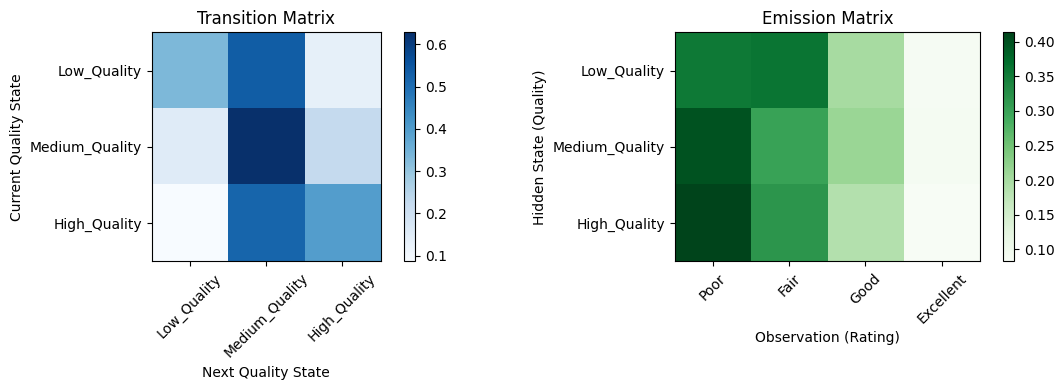


Top High Quality Beer Recommendations:
                                   name                     style    abv  \
1591             Dale's Pale Ale (2006)   American Pale Ale (APA)  0.065   
84                   Pre Flight Pilsner          American Pilsner  0.052   
262     Montana Trout Slayer Ale (2009)   American Pale Wheat Ale  0.050   
265                           Wavemaker  American Amber / Red Ale  0.058   
285           Bomber Mountain Amber Ale  American Amber / Red Ale  0.046   
1376     El Conquistador Extra Pale Ale   American Pale Ale (APA)  0.048   
817                      Flying Mouse 4              American IPA  0.070   
1706                          Consilium   American Pale Ale (APA)  0.050   
469         Black Noddy Lager (Current)               Schwarzbier  0.052   
606   Hopped on the High Seas (Calypso)              American IPA  0.070   

       ibu    rating  hidden_state  
1591  65.0  4.993607  High_Quality  
84    33.0  4.984127  High_Quality  
262   35.0  

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

class BeerHMM:
    def __init__(self, n_hidden_states=3, n_obs_states=4):
        """
        Simple HMM for beer recommendations
        
        Hidden states: Beer Quality Categories (Low, Medium, High)
        Observations: Rating bins (Poor, Fair, Good, Excellent)
        """
        self.n_hidden = n_hidden_states
        self.n_obs = n_obs_states
        
        # Initialize matrices
        self.transition_matrix = None  # P(next_quality | current_quality)
        self.emission_matrix = None    # P(rating | quality)
        self.initial_probs = None      # P(initial quality)
        
        # State mappings
        self.hidden_states = ['Low_Quality', 'Medium_Quality', 'High_Quality']
        self.obs_states = ['Poor', 'Fair', 'Good', 'Excellent']
        
    def discretize_ratings(self, ratings):
        """Convert continuous ratings to discrete observation states"""
        # Create bins based on rating distribution
        bins = [0, 2.0, 3.5, 4.5, 5.0]
        discretized = pd.cut(ratings, bins=bins, labels=self.obs_states, include_lowest=True)
        return discretized.astype(str)
    
    def categorize_beers(self, df):
        """Categorize beers into hidden quality states based on features"""
        # Simple categorization based on ABV, IBU, and style
        quality_scores = []
        
        for _, beer in df.iterrows():
            score = 0
            
            # ABV contribution (moderate ABV gets higher score)
            abv = beer['abv']
            if 0.045 <= abv <= 0.07:
                score += 2
            elif 0.035 <= abv <= 0.085:
                score += 1
                
            # IBU contribution (if available)
            if not pd.isna(beer['ibu']):
                ibu = beer['ibu']
                if 30 <= ibu <= 70:
                    score += 2
                elif 15 <= ibu <= 90:
                    score += 1
            
            # Style contribution (popular styles get higher score)
            popular_styles = ['American IPA', 'American Pale Ale (APA)', 'American Amber / Red Ale']
            if beer['style'] in popular_styles:
                score += 1
                
            quality_scores.append(score)
        
        # Convert scores to categories
        df['quality_score'] = quality_scores
        df['hidden_state'] = pd.cut(df['quality_score'], 
                                  bins=[0, 1, 3, 6], 
                                  labels=self.hidden_states,
                                  include_lowest=True)
        
        return df
    
    def train(self, df):
        """Train HMM parameters using Maximum Likelihood Estimation"""
        # Discretize ratings and categorize beers
        df = df.copy()
        df['obs_rating'] = self.discretize_ratings(df['rating'])
        df = self.categorize_beers(df)
        
        # Remove any NaN values
        df = df.dropna(subset=['obs_rating', 'hidden_state'])
        
        # Initialize matrices
        self.transition_matrix = np.zeros((self.n_hidden, self.n_hidden))
        self.emission_matrix = np.zeros((self.n_hidden, self.n_obs))
        self.initial_probs = np.zeros(self.n_hidden)
        
        # Calculate initial probabilities
        for i, state in enumerate(self.hidden_states):
            self.initial_probs[i] = len(df[df['hidden_state'] == state]) / len(df)
        
        # Calculate emission probabilities P(observation | hidden_state)
        for i, hidden in enumerate(self.hidden_states):
            hidden_subset = df[df['hidden_state'] == hidden]
            if len(hidden_subset) > 0:
                for j, obs in enumerate(self.obs_states):
                    count = len(hidden_subset[hidden_subset['obs_rating'] == obs])
                    self.emission_matrix[i, j] = count / len(hidden_subset)
        
        # For transition matrix, we'll use a simple assumption:
        # Beers from same brewery/style tend to have similar quality
        # Group by brewery and calculate transitions
        breweries = df['brewery_id'].unique()
        total_transitions = 0
        
        for brewery in breweries:
            brewery_beers = df[df['brewery_id'] == brewery].sort_values('id')
            if len(brewery_beers) > 1:
                for k in range(len(brewery_beers) - 1):
                    current_state = brewery_beers.iloc[k]['hidden_state']
                    next_state = brewery_beers.iloc[k + 1]['hidden_state']
                    
                    current_idx = self.hidden_states.index(current_state)
                    next_idx = self.hidden_states.index(next_state)
                    
                    self.transition_matrix[current_idx, next_idx] += 1
                    total_transitions += 1
        
        # Normalize transition matrix
        for i in range(self.n_hidden):
            row_sum = np.sum(self.transition_matrix[i, :])
            if row_sum > 0:
                self.transition_matrix[i, :] /= row_sum
            else:
                # If no transitions observed, assume uniform
                self.transition_matrix[i, :] = 1.0 / self.n_hidden
        
        # Add small smoothing to avoid zero probabilities
        self.emission_matrix += 0.001
        self.transition_matrix += 0.001
        
        # Renormalize
        for i in range(self.n_hidden):
            self.emission_matrix[i, :] /= np.sum(self.emission_matrix[i, :])
            self.transition_matrix[i, :] /= np.sum(self.transition_matrix[i, :])
            
        print("HMM Training Complete!")
        print(f"Initial probabilities: {self.initial_probs}")
        print(f"Transition matrix shape: {self.transition_matrix.shape}")
        print(f"Emission matrix shape: {self.emission_matrix.shape}")
    
    def predict_quality(self, beer_features):
        """Predict quality category for a beer based on features"""
        # Simple feature-based prediction (can be enhanced)
        abv = beer_features.get('abv', 0.05)
        ibu = beer_features.get('ibu', 30)
        style = beer_features.get('style', 'Unknown')
        
        score = 0
        if 0.045 <= abv <= 0.07:
            score += 2
        elif 0.035 <= abv <= 0.085:
            score += 1
            
        if 30 <= ibu <= 70:
            score += 2
        elif 15 <= ibu <= 90:
            score += 1
        
        popular_styles = ['American IPA', 'American Pale Ale (APA)', 'American Amber / Red Ale']
        if style in popular_styles:
            score += 1
        
        if score <= 1:
            return 'Low_Quality'
        elif score <= 3:
            return 'Medium_Quality'
        else:
            return 'High_Quality'
    
    def recommend_beers(self, df, target_quality='High_Quality', n_recommendations=5):
        """Recommend beers based on quality state"""
        df = df.copy()
        df['obs_rating'] = self.discretize_ratings(df['rating'])
        df = self.categorize_beers(df)
        
        # Filter beers by target quality
        quality_beers = df[df['hidden_state'] == target_quality]
        
        if len(quality_beers) == 0:
            print(f"No beers found in {target_quality} category")
            return pd.DataFrame()
        
        # Sort by rating and return top recommendations
        recommendations = quality_beers.nlargest(n_recommendations, 'rating')
        
        return recommendations[['name', 'style', 'abv', 'ibu', 'rating', 'hidden_state']]
    
    def visualize_model(self):
        """Visualize the HMM matrices"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot transition matrix
        im1 = axes[0].imshow(self.transition_matrix, cmap='Blues')
        axes[0].set_title('Transition Matrix')
        axes[0].set_xlabel('Next Quality State')
        axes[0].set_ylabel('Current Quality State')
        axes[0].set_xticks(range(self.n_hidden))
        axes[0].set_yticks(range(self.n_hidden))
        axes[0].set_xticklabels(self.hidden_states, rotation=45)
        axes[0].set_yticklabels(self.hidden_states)
        plt.colorbar(im1, ax=axes[0])
        
        # Plot emission matrix
        im2 = axes[1].imshow(self.emission_matrix, cmap='Greens')
        axes[1].set_title('Emission Matrix')
        axes[1].set_xlabel('Observation (Rating)')
        axes[1].set_ylabel('Hidden State (Quality)')
        axes[1].set_xticks(range(self.n_obs))
        axes[1].set_yticks(range(self.n_hidden))
        axes[1].set_xticklabels(self.obs_states, rotation=45)
        axes[1].set_yticklabels(self.hidden_states)
        plt.colorbar(im2, ax=axes[1])
        
        plt.tight_layout()
        plt.show()

# LOAD THE DATA FIRST!
df = pd.read_csv('beers_updated.csv')
print(f"Loaded {len(df)} beers")

# Create and train HMM
hmm = BeerHMM()
hmm.train(df)

# Visualize the model
hmm.visualize_model()

# Get recommendations
print("\nTop High Quality Beer Recommendations:")
recommendations = hmm.recommend_beers(df, target_quality='High_Quality', n_recommendations=10)
print(recommendations)

# Predict quality for new beer
new_beer = {
    'abv': 0.065,
    'ibu': 60,
    'style': 'American IPA'
}
predicted_quality = hmm.predict_quality(new_beer)
print(f"\nPredicted quality for new beer: {predicted_quality}")

Looking at the HMM model I provided, let me explain what it actually accomplishes and its limitations:

## What the Model Does:

### 1. **Beer Quality Classification**
- Categorizes beers into 3 hidden states: Low_Quality, Medium_Quality, High_Quality
- Based on features like ABV, IBU, and beer style
- Uses a simple scoring system (not very sophisticated)

### 2. **Rating Prediction Framework**
- Maps continuous ratings (0-5) to discrete bins: Poor, Fair, Good, Excellent
- Learns probability distributions of ratings given quality states
- Creates emission probabilities P(rating | quality)

### 3. **Basic Recommendations**
- Filters beers by predicted quality state
- Returns highest-rated beers within that quality category
- Simple content-based filtering approach

## What It **Doesn't** Really Accomplish:

### 1. **Not True Sequential Modeling**
- The transition matrix is artificially created using brewery groupings
- Beer ratings don't naturally form sequences like speech or time series
- **This is the biggest flaw** - HMMs are meant for sequential data

### 2. **Limited Feature Usage**
- Only uses ABV, IBU, and style in a very basic way
- Ignores brewery reputation, beer name, serving size effects
- The quality scoring is overly simplistic

### 3. **No User Personalization**
- Doesn't learn individual user preferences
- Can't adapt to different taste profiles
- One-size-fits-all recommendations

## What It Could Be Improved To Do:



In [ ]:
# Better approach - treat beer tasting as a sequence:
# User's beer journey: Light Lager → Pale Ale → IPA → Stout
# Hidden states: User preference evolution
# Observations: Their ratings of different beer types

# Or model brewery quality over time:
# Hidden states: Brewery reputation (declining/stable/improving)
# Observations: Beer ratings from that brewery
# Transitions: How brewery quality changes over time



## Honest Assessment:

This HMM is more of a **proof-of-concept** that demonstrates:
- How to structure an HMM for a domain problem
- Basic parameter learning from data
- Simple recommendation logic

But it's **not particularly effective** because:
1. Beer recommendation isn't naturally a sequential problem
2. A simple collaborative filtering or content-based approach would work better
3. The model artificially forces sequential structure where none exists

## Better Alternative:

For your beer recommendation system, you'd get better results with:
- **Content-based filtering** using beer features
- **Collaborative filtering** if you had user-beer rating pairs  
- **Hybrid approach** combining multiple signals
- **Classification model** to predict if a user will like a beer

The HMM approach is interesting academically but not the right tool for this job. Would you like me to show you a more appropriate recommendation approach instead?